In [114]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from functools import partial
from torch.autograd.functional import jacobian, hessian

from torchdiffeq import odeint as tor_odeint
from torchdiffeq import odeint_adjoint as tor_odeintadj
torch.version.__version__

'1.5.1'

Lagrangian for spring pendulum, in 2D, with $r$ spring length, $\theta$ angle from vertical: 

$\mathcal{L} = T - V = \frac{1}{2}\dot{r}^2 + \frac{1}{2} r^2\dot{\theta}^2 - gr(1-\cos(\theta)) - k(r -r_0)^2$

By applying Euler Lagrange equataions get:

$\ddot r = r\dot{\theta}^2 + g(1-\cos(\theta)) - 2k(r-r_0)$

and 

$\ddot \theta = -\frac{1}{r}(g\sin(\theta) + 2\dot{r}\dot{\theta})$

can use these and `odeint` to solve analytically.



In [13]:
def lagrangian(x, g=10, k=10):
    q, qt = torch.split(x, 2)
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2
    return T - V 

def E(x, g=10, k=10):
    try:
        q, qt = torch.split(x, 2)
        cos = torch.cos
    except: 
        q, qt = np.split(x, 2)
        cos = np.cos
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-cos(q[1])) + k*(q[0] - 1)**2
    return T + V 


In [35]:
def get_qdtt(q, qt, g=10, k=10):
    '''
    q is array of genralise coords, [r, theta]
    qt is array of genralise coords, [rdt, thetadt]

    returns time derivative of q.
    '''
    qdtt = np.zeros_like(q)

    qdtt[:, 0] = q[:, 0]*qt[:, 1]**2 - g*(1-np.cos(q[:, 1])) - 2*k*(q[:, 0]-1) 
    qdtt[:, 1] = (-g*np.sin(q[:, 1]) -2*qt[:, 0]*qt[:, 1])/q[:, 0]

    return qdtt  

def get_xt_anal(x, t):
    d = np.zeros_like(x)
    d[:, :2] = x[:, 2:]
    d[:, 2:] = get_qdtt(x[:, :2], x[:, 2:])

    # print(x, d)
    return d

def anal_solve_ode(q0, qt0, t,):

    x0 = np.append(q0, qt0)

    def f_anal(x, t):
        d = np.zeros_like(x)
        d[:2] = x[2:]
        d[2:] = np.squeeze(get_qdtt(np.expand_dims(x[:2], axis=0), np.expand_dims(x[2:], axis=0)))
        # print(x, d)
        return d
    
    return odeint(f_anal, x0, t, rtol=1e-10, atol=1e-10)
    
def q2xy(ql):
    '''
    Polar coords to xy
    '''
    try: 
        xy = np.zeros_like(ql)
        sin = np.sin
        cos = np.cos
    except: 
        xy = torch.zeros_like(ql)
        sin = torch.sin
        cos = torch.cos

    xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
    xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
    return xy  


In [41]:
t = np.arange(0, 5, 0.005)

q0 = np.array([1.1, 0.5])
q0p = np.array([1.1 + 1e-5, 0.5])
qt0 = np.array([0.0, 0.0])

%timeit path = anal_solve_ode(q0, qt0, t)
ppath = anal_solve_ode(q0p, qt0, t)
xy = q2xy(path)
pxy = q2xy(ppath)

31.3 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


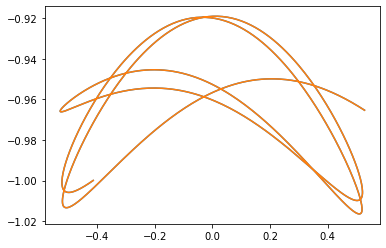

In [37]:
plt.plot(xy[:, 0], xy[:, 1])
plt.plot(pxy[:, 0], pxy[:, 1])

We can also solve using pytorch to autodiff the lagrangian, an use the following version of the EL equations (after Cranmer et al.), with $q=(r, \theta)$:

$\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q]$





In [38]:
def get_xt(lagrangian, t, x):
    n = x.shape[0]//2
    xv = torch.autograd.Variable(x, requires_grad=True)
    tq, tqt = torch.split(xv, 2, dim=0)

    A = torch.inverse(hessian(lagrangian, xv, create_graph=True)[n:, n:])
    B = jacobian(lagrangian, xv, create_graph=True)[:n]
    C = hessian(lagrangian, xv, create_graph=True)[n:, :n]

    tqtt = A @ (B - C @ tqt)

    xt = torch.cat([tqt, torch.squeeze(tqtt)])

    return xt


def torch_solve_ode(x0, t, lagrangian):
    f = partial(get_xt, lagrangian)
    return tor_odeint(f, x0, t)

In [40]:
tx0 = torch.cat([torch.tensor(q0), torch.tensor(qt0)])
tt = torch.tensor(t)
%timeit tpath = torch_solve_ode(tx0, tt, lagrangian)
txy = q2xy(tpath)

6.7 s ± 87.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


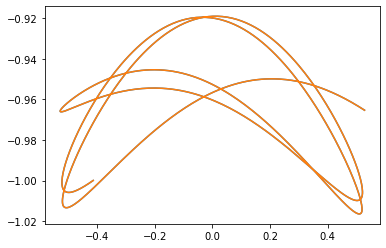

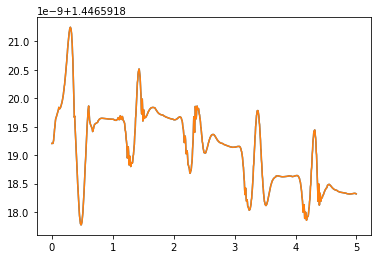

In [153]:
plt.plot(xy[:, 0], xy[:, 1])
plt.plot(txy[:, 0], txy[:, 1])
En = [E(x) for x in path]
Ent = [E(x) for x in tpath]
plt.show()
plt.plot(t, En)
plt.plot(t, Ent)
plt.show()

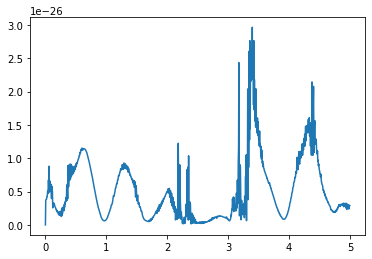

In [154]:
plt.plot(t, np.sum((tpath - path)**2, axis=1))

In [44]:
def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [67]:
t_train = torch.tensor(np.linspace(0, 10, 1500)).float()
t_test = torch.tensor(np.linspace(10, 20, 1500)).float()

tstep = t_train[1].item() 

x_train = torch.tensor(anal_solve_ode(q0, qt0, t_train)).float()
xt_train = torch.tensor(get_xt_anal(x_train, t_train)).float()
y_train = torch.tensor(rk4_step(get_xt_anal, x_train, t_train, tstep)).float()

x_test = torch.tensor(anal_solve_ode(q0, qt0, t_test)).float()
xt_test = torch.tensor(get_xt_anal(x_test, t_test)).float()
y_test = torch.tensor(rk4_step(get_xt_anal, x_test, t_test, tstep)).float()


In [145]:
class LNN(nn.Module):
    def __init__(self):
        super(LNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def lagrangian(self, x): 
        x = F.softmax(self.fc1(x))
        x = F.softmax(self.fc2(x))
        x = self.fc3(x)
        return x 

    def forward(self, x):

        n = x.shape[1]//2
        xv = torch.autograd.Variable(x, requires_grad=True)
        xv_tup = tuple([xi for xi in x]) 

        tqt = xv[:, n:]


        jacpar = partial(jacobian,  self.lagrangian, create_graph=True)
        hesspar = partial(hessian,  self.lagrangian, create_graph=True)

        A = tuple(map(hesspar, xv_tup))
        B = tuple(map(jacpar, xv_tup))

        
        multi = lambda Ai, Bi, tqti, n:  torch.inverse(Ai[n:, n:]) @ (Bi[:n, 0] - Ai[n:, :n] @ tqti) 
        multi_par = partial(multi, n=n)

        tqtt_tup = tuple(map(multi_par, A, B, tqt))
        tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])

        xt = torch.cat([tqt, tqtt], axis=1)
        xt.retain_grad()
        return xt

    def t_forward(self, t, x):
        return self.forward(x)



    
def loss(pred, targ):
    return torch.mean((pred - targ)**2)

def nn_solve_ode(model, x0, t):

    x0 = x0.detach().numpy()
    def f(x, t):
        x_tor = torch.tensor(np.expand_dims(x, 0), requires_grad=True).float()
        return np.squeeze(model(x_tor).detach().numpy(), axis=0)
    return odeint(f, x0, t)  

In [134]:
eps = 100
N = 1500 
batch_size = 100 

model = LNN()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_list = []
for e in range(eps):
    running_loss = 0.
    for i in range(1, N // batch_size):
        optimizer.zero_grad()
        xi = xt_train[(i-1)*batch_size:i*batch_size]
        xt_pred = model(xi)

        loss_val = loss(xt_pred, xt_train[i])
        loss_val.backward()

        optimizer.step()



        running_loss += loss_val.item()


    print('[%d, %5d] loss: %.10f' %
          (e + 1, i + 1, running_loss/N))
    
    loss_list.append(running_loss/N)
    running_loss = 0.0
        
        

[1,    15] loss: 455.2153637975
[2,    15] loss: 9.7381901016
[3,    15] loss: 29.1845553964
[4,    15] loss: 63.8707298787
[5,    15] loss: 37.2992564697
[6,    15] loss: 39.5541002579
[7,    15] loss: 14.5610445531
[8,    15] loss: 3.1170572319
[9,    15] loss: 2.5411200695
[10,    15] loss: 2.5637215309
[11,    15] loss: 2.5671767139
[12,    15] loss: 2.5433052311
[13,    15] loss: 2.5168358434
[14,    15] loss: 2.4936192252
[15,    15] loss: 2.4737230962
[16,    15] loss: 2.4561784185
[17,    15] loss: 2.4401843039
[18,    15] loss: 2.4254116166
[19,    15] loss: 2.4116630898
[20,    15] loss: 2.3987121499
[21,    15] loss: 2.3866905460
[22,    15] loss: 2.3753447901
[23,    15] loss: 2.3647259032
[24,    15] loss: 2.3547427578
[25,    15] loss: 2.3454292272
[26,    15] loss: 2.3366362222
[27,    15] loss: 2.3284198926


KeyboardInterrupt: 

In [147]:

nn_test = nn_solve_ode(model, x_train[0], t_train)


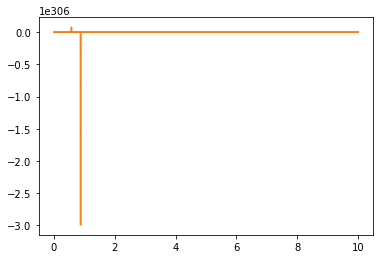

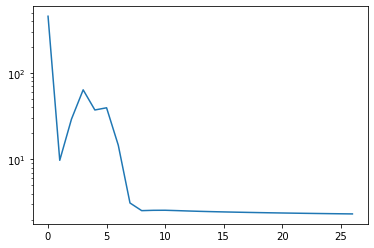

In [148]:
plt.plot(t_train, x_train[:, 0])
plt.plot(t_train, nn_test[:, 0])
plt.show()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.yscale('log')


In [149]:
for i in range(10):
    print((nn_test[i], x_train[i]))

(array([1.10000002, 0.5       , 0.        , 0.        ]), tensor([1.1000, 0.5000, 0.0000, 0.0000]))
(array([1.10001986, 0.50017215, 0.00639064, 0.0529767 ]), tensor([ 1.0999,  0.4999, -0.0215, -0.0291]))
(array([1.10009267, 0.50072905, 0.01613579, 0.11604361]), tensor([ 1.0997,  0.4996, -0.0430, -0.0582]))
(array([1.10024763, 0.50175655, 0.03160623, 0.19565146]), tensor([ 1.0994,  0.4991, -0.0644, -0.0873]))
(array([1.10054152, 0.50341503, 0.05997762, 0.31107476]), tensor([ 1.0989,  0.4984, -0.0856, -0.1164]))
(array([1.10092408, 0.50520762, 0.13313947, 0.53411951]), tensor([ 1.0982,  0.4976, -0.1068, -0.1456]))
(array([-4.02853669e-196, -2.54555040e-107,  6.73326509e-250,
       -1.56545976e-267]), tensor([ 1.0974,  0.4965, -0.1277, -0.1748]))
(array([-5.64080106e-294, -1.30961378e-266,  3.11432868e+279,
        4.49510357e+260]), tensor([ 1.0965,  0.4952, -0.1484, -0.2040]))
(array([-8.42783858e+162, -3.77048338e-132, -2.02912998e+077,
       -7.59058940e-095]), tensor([ 1.0955,  0.4

In [164]:
xt_train

tensor([[ 0.0000,  0.0000, -3.2242, -4.3584],
        [-0.0215, -0.0291, -3.2213, -4.3591],
        [-0.0430, -0.0582, -3.2129, -4.3610],
        ...,
        [-0.4281, -1.6524,  3.5576, -3.0637],
        [-0.4040, -1.6722,  3.6836, -2.8887],
        [-0.3790, -1.6909,  3.8023, -2.7047]])